<a href="https://colab.research.google.com/github/Arindam75/graph_networks/blob/main/02_node_2_vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU gensim

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
random.seed(0)

In [ ]:
G = nx.karate_club_graph()

In [ ]:
labels = []
for node in G.nodes:

  label = G.nodes[node]['club']
  labels.append(1 if label == 'Officer' else 0)

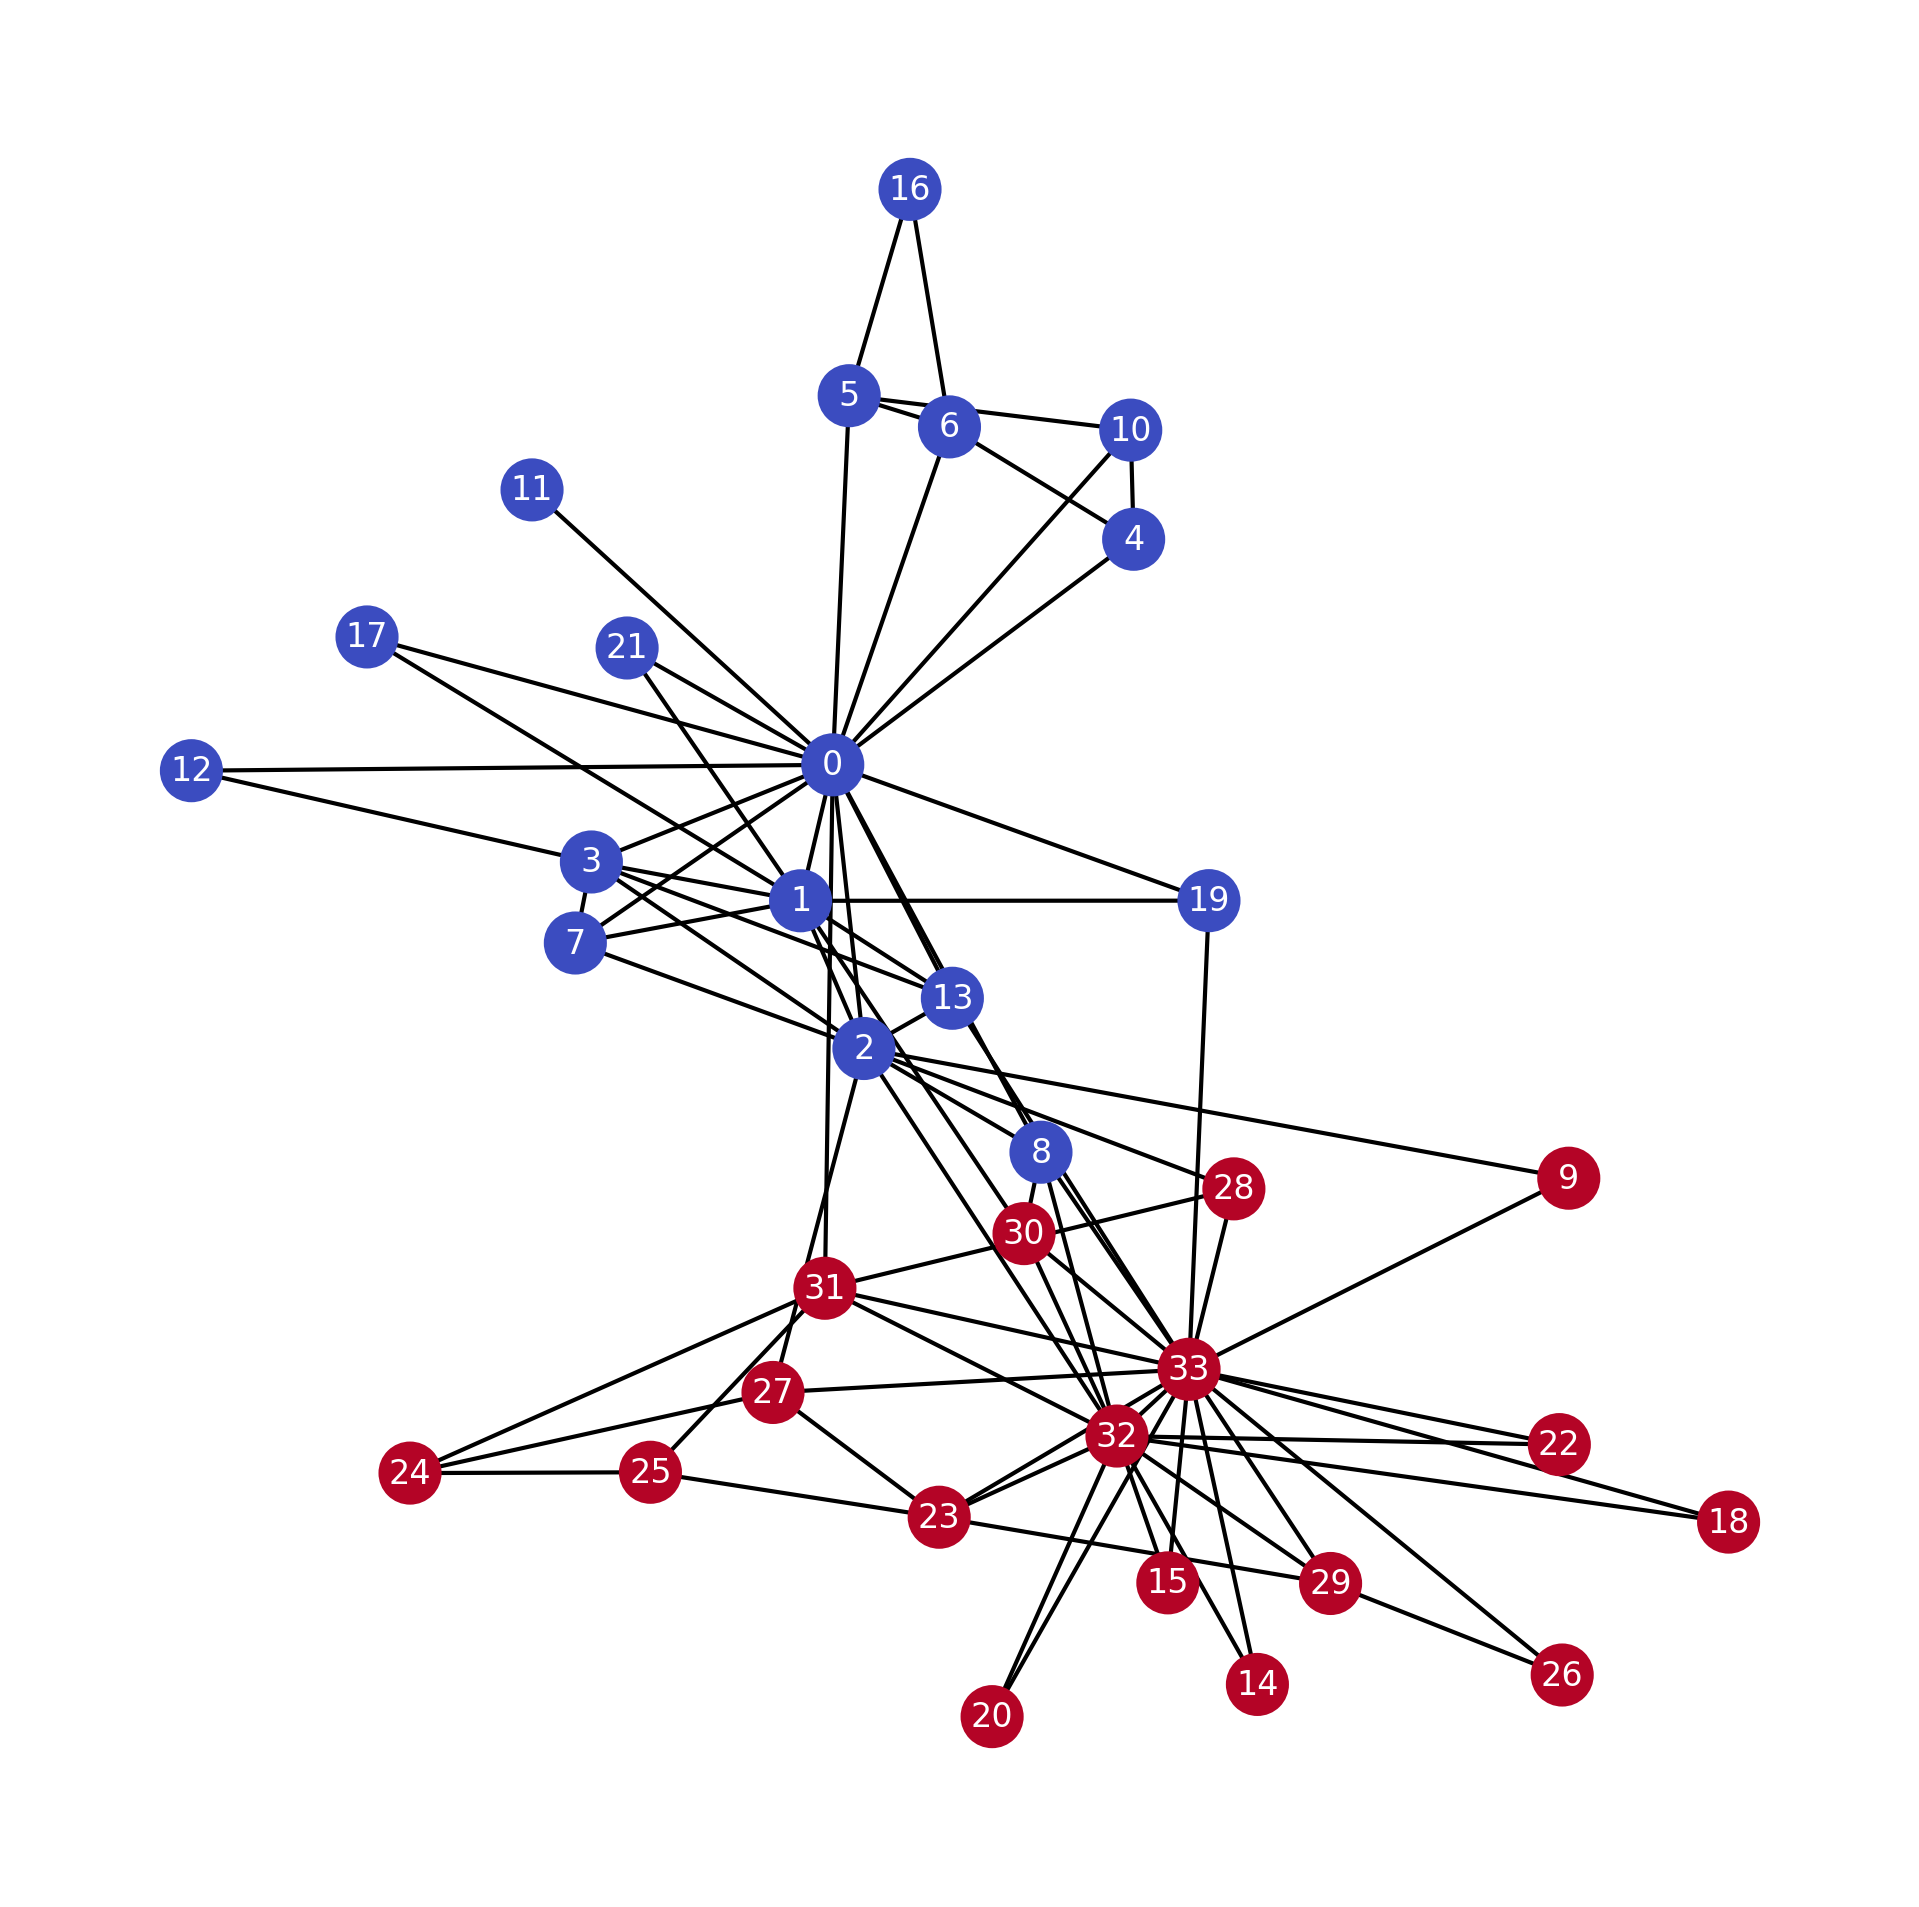

In [ ]:
plt.figure(figsize=(8,8), dpi=300)
plt.axis('off')
nx.draw_networkx(G,
pos=nx.spring_layout(G, seed=0),
                    node_color=labels,
                    node_size=200,
                    cmap='coolwarm',
                    font_size=8,
                    font_color='white'
                    )

In [ ]:
def next_node(prev_node, crnt_node, p , q):

  neighbors = list(G.neighbors(crnt_node))
  alphas = []
  for nebor in neighbors:
    if nebor == prev_node:
      alpha = 1/p
    elif G.has_edge(nebor, prev_node):
      alpha = 1
    else:
      alpha = 1/q
    alphas.append(alpha)

  probs = np.array(alphas)/np.sum(alphas)
  next = np.random.choice(neighbors, 1, p=probs)[0]

  return next

def biased_random_walk(start, length, p , q):

  walk = [start]
  for i in range(length):
    current = walk[-1]
    previous = walk[-2] if len(walk) > 1 else None
    next = next_node(previous, current, p, q)
    walk.append(next)

  return walk

Setting p and q as 1 is same as the deep walk algorith. Every neighboring node has the same probability of being visited.

In [ ]:
biased_random_walk(0, 8, p=1, q=1)

[0, 2, 9, 2, 13, 33, 9, 2, 32]

Setting a higher values q , makes it more likely to go back to the previous node

In [ ]:
biased_random_walk(0, 8, p=1, q=10)

[0, 17, 0, 17, 1, 0, 21, 0, 3]

Finally, setting higher p makes it less likely to go back to the previous node

In [ ]:
biased_random_walk(0, 8, p=10, q=1)

[0, 21, 0, 31, 28, 31, 24, 27, 23]

In [ ]:
walks = []
p = 3
q = 2
for node in G.nodes:
  for i in range(80):
    walks.append(biased_random_walk(node, 10, p ,q))

At this point we have a list of walks, each walk is a list of nodes. For each node 80 walks, therefore making it 34*80 = 2720 walks. We can print 10 such random walks.

In [ ]:
n_walks = len(walks)
random_samples = np.random.choice(n_walks, 10)
[walks[i] for i in random_samples]

[[30, 32, 2, 0, 4, 6, 16, 5, 6, 16, 5],
 [32, 8, 0, 17, 1, 0, 2, 7, 1, 0, 19],
 [5, 0, 3, 2, 13, 2, 7, 1, 2, 0, 13],
 [2, 8, 33, 26, 29, 33, 14, 33, 22, 32, 33],
 [12, 0, 19, 33, 28, 31, 33, 19, 1, 13, 3],
 [16, 6, 4, 10, 0, 6, 5, 6, 0, 5, 10],
 [16, 5, 0, 10, 4, 0, 5, 6, 16, 5, 0],
 [12, 0, 10, 5, 0, 1, 19, 33, 23, 29, 23],
 [15, 32, 22, 33, 31, 0, 8, 0, 3, 12, 0],
 [32, 18, 33, 9, 33, 30, 8, 33, 32, 18, 33]]

In [ ]:
node_2_vec = Word2Vec(walks,
                hs=1, # Hierarchical softmax
                sg=1, # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                seed=0)

node_2_vec.train(walks, total_examples=node_2_vec.corpus_count,
epochs=30, report_delay=1)

(185840, 897600)

In [ ]:
node_embs = np.array([node_2_vec.wv.get_vector(i) for i in range(len(node_2_vec.wv))])
labels = np.array(labels)

We can now extract the embeddings of the nodes and build a tsne visualization out of it

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
node_count = node_embs.shape[0]
train_nodes = np.random.choice(node_count,int(node_count*0.70))
test_nodes = [i for i in range(node_count) if i not in train_nodes]

In [ ]:
clf = RandomForestClassifier(random_state=0)
clf.fit(node_embs[train_nodes],labels[train_nodes])

RandomForestClassifier(random_state=0)

In [ ]:
y_pred = clf.predict(node_embs[test_nodes])
accuracy_score(y_pred, labels[test_nodes])

1.0